### Burst statistics

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/vanderbilt")

In [2]:
import os
from functools import partial

import emd
import igraph as ig
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numba as nb
import numpy as np
import PyEMD
import scipy
import seaborn as sns
import skimage as ski
import xarray as xr
from frites.conn.conn_sliding_windows import define_windows
from frites.utils import parallel_func
from mne.time_frequency import tfr_array_morlet
from scipy.optimize import curve_fit
from skimage.segmentation import watershed
from tqdm import tqdm

from config import metadata
from VUDA.emd import emd_vec
from VUDA.io.loadbinary import LoadBinary

In [3]:
# Global flag to set a specific platform, must be used at startup.
jax.config.update("jax_platform_name", "cpu")

#### Functions

In [4]:
def overlaps(theta_timings: list, gamma_timings: list):
    n_theta = len(theta_timings)
    n_gamma = len(gamma_timings)

    n_overlaps = np.empty(n_gamma, dtype=np.int64)

    for i in range(n_gamma):
        temp = np.logical_and(
            theta_timings[:, 0] - gamma_timings[i, 0] < 0,
            theta_timings[:, 1] - gamma_timings[i, 0] > 0,
        )

        temp = np.logical_and(
            temp,
            np.logical_and(
                theta_timings[:, 0] - gamma_timings[i, 1] < 0,
                theta_timings[:, 1] - gamma_timings[i, 1] > 0,
            ),
        )

        n_overlaps[i] = temp.sum()

    return n_overlaps

In [5]:
def replace_zeros_with_nan(arr):
    """
    Replaces zeros in a JAX array with NaNs.

    Parameters:
        arr (jax.numpy.ndarray): Input array.

    Returns:
        jax.numpy.ndarray: Array with zeros replaced by NaNs.
    """
    return jnp.where(arr == 0, jnp.nan, arr)


def get_n_channels(bursts: np.ndarray, label: int):
    """
    Calculates the maximum number of channels associated with a given label.

    Parameters:
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute channels for.

    Returns:
        int: Maximum number of channels associated with the given label.
    """

    def _for_label(carry, label):
        return (bursts == label).sum(0).max()

    _, out = jax.lax.scan(_for_label, None, labels)
    return np.array(out)


def get_masked_feature(vector: np.ndarray, bursts: np.ndarray, label: int):
    """
    Masks the feature vector based on the given label.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to mask the feature vector.

    Returns:
        numpy.ndarray: Masked feature vector.
    """
    return (bursts == label) * vector


def stats_feature(
    vector: np.ndarray, bursts: np.ndarray, labels: int, fstats=jnp.nanmean
):
    """
    Computes the average of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the average for.

    Returns:
        float: Average of non-zero elements in the masked feature vector.
    """

    def _for_label(carry, label):
        masked = get_masked_feature(vector, bursts, label)
        return carry, fstats(replace_zeros_with_nan(masked))

    _, out = jax.lax.scan(_for_label, None, labels)
    return out


def get_spread(nobs: int, bursts: np.ndarray, labels: int, axes: tuple):
    """
    Computes the spatial spread of a particular label.

    Parameters:
        nobs (int): Number of channels.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the spatial spread for.

    Returns:
        numpy.ndarray: Array containing the minimum and maximum channel indices.
    """

    def _for_label(carry, label):
        out = jnp.nonzero((bursts == label).sum(axes), size=nobs, fill_value=jnp.nan)[0]
        ci, cf = jnp.nanmin(out), jnp.nanmax(out)
        return carry, jnp.array([ci, cf])

    _, out = jax.lax.scan(_for_label, None, labels)

    return out

In [6]:
def get_stats_feature_blocks(
    blocks: np.ndarray, vector: np.ndarray, bursts: np.ndarray, fstats=jnp.nanmean
):
    nblocks = len(blocks)
    bursts = jnp.array(bursts, dtype=jnp.int16)
    max_labels = bursts.max((1, 2))
    max_label = max_labels.max()

    def _for_block(carry, block):
        burst_array = bursts[block]
        labels = jnp.unique(burst_array, size=max_label, fill_value=-1)[1:]
        out = stats_feature(vector, burst_array, labels, fstats)
        return carry, out

    _, out = jax.lax.scan(_for_block, None, blocks)
    out = jax.device_put(out, jax.devices("cpu")[0])
    return out


def get_spread_blocks(blocks: np.ndarray, nobs: int, bursts: np.ndarray, axes: tuple):

    nblocks = len(blocks)
    bursts = jnp.array(bursts, dtype=jnp.int16)
    max_labels = bursts.max((1, 2))
    max_label = max_labels.max()

    def _for_block(carry, block):
        burst_array = bursts[block]
        labels = jnp.unique(burst_array, size=max_label, fill_value=-1)[1:]
        return carry, get_spread(nobs, burst_array, labels, axes)

    _, out = jax.lax.scan(_for_block, None, blocks)
    out = jax.device_put(out, jax.devices("cpu")[0])
    # out = [out[i, 0 : max_label[i]] for i in range(nblocks)]
    return out

#### Load data

In [7]:
date = "10-13-2022"
monkey = "FN"
# date = "2021-09-24"
# monkey = "WI"
max_imfs = None
method = "eemd"
condition = "task"


base_path = os.path.expanduser(f"~/funcog/HoffmanData/{monkey}/{date}")

composites_path = os.path.join(
    base_path, f"composite_signals_{condition}_method_eemd_max_imfs_None_std_False.nc"
)

ps_composites_path = os.path.join(
    base_path,
    f"ps_composite_signals_{condition}_method_eemd_max_imfs_None_std_False.nc",
)

In [8]:
impath = f"figures/{monkey}/{date}/"

if not os.path.isdir(impath):
    os.makedirs(impath)

In [9]:
composites = xr.open_dataset(composites_path)
ps_composites = xr.open_dataset(ps_composites_path)

In [10]:
channels = list(composites.keys())
nchannels = len(channels)

#### Load burts - single channel

In [11]:
def load_bursts(channel: str = None):
    _base = os.path.join(base_path, "bursts")
    fname = (
        f"labeled_bursts_{channel}_{condition}_method_eemd_max_imfs_None_std_False.nc"
    )
    fname = os.path.join(_base, fname)
    return xr.load_dataarray(fname)

In [12]:
def load_spec(channel: str = None):
    _base = os.path.join(base_path, "bursts")
    fname = f"spectogram_{channel}_{condition}_method_eemd_max_imfs_None_std_False.nc"
    fname = os.path.join(_base, fname)
    return xr.load_dataarray(fname)

In [13]:
bursts = (load_bursts(channel="channel1")).astype(int)
W = (load_spec(channel="channel1")).astype(int)

In [16]:
nblocks, nimfs, nfreqs, ntimes = bursts.shape
times = bursts.times.data
freqs = bursts.freqs.data

In [17]:
get_spectral_spread = lambda blocks, nfreqs, bursts: get_spread_blocks(
    blocks, nfreqs, bursts, (1)
)
get_temporal_spread = lambda blocks, ntimes, bursts: get_spread_blocks(
    blocks, ntimes, bursts, (0)
)
"""
@partial(jax.vmap, in_axes=(0, None, None, None))
def get_spectral_spread_blocks(
    block: int, labels: jnp.ndarray, max_label: int, n_freqs: int
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return get_spectral_spread(
        n_freqs,
        labels[block],
        unique_labels,
    )


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_temporal_spread_blocks(
    block: int, labels: jnp.ndarray, max_label: int, n_times: int
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return get_temporal_spread(
        n_times,
        labels[block],
        unique_labels,
    )


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_duration_blocks(
    block: int, labels: jnp.ndarray, max_label: int, times: np.ndarray
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return get_duration(times, labels[block], unique_labels)


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_average_spread_blocks(
    block: int, labels: jnp.ndarray, max_label: int, vector: np.ndarray
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return (
        average_feature(vector, labels[block], unique_labels),
        spread_feature(vector, labels[block], unique_labels),
    )
""";

In [19]:
features_names = [
    "average(time)",
    "std(time)",
    "temp_spread",
    "average(freq)",
    "sig(freq)",
    "spec_spread",
]

features = {}
for key in features_names:
    features[key] = []

blocks = jnp.asarray(bursts.blocks.data)
sel_bursts = bursts.sel(IMFs=0)

mu_time, sig_time = get_stats_feature_blocks(
    blocks, times, sel_bursts.data, fstats=jnp.nanmean
), get_stats_feature_blocks(blocks, times, sel_bursts.data, fstats=jnp.nanstd)

mu_freq, sig_freq = get_stats_feature_blocks(
    blocks, freqs[:, None], sel_bursts.data, fstats=jnp.nanmean
), get_stats_feature_blocks(blocks, freqs[:, None], sel_bursts.data, fstats=jnp.nanstd)

temp_spread = get_temporal_spread(blocks, ntimes, sel_bursts.data)

spec_spread = get_spectral_spread(blocks, ntimes, sel_bursts.data)


temp = [
    mu_time,
    sig_time,
    temp_spread,
    mu_freq,
    sig_freq,
    spec_spread,
]

for j, key in enumerate(features_names):
    features[key] = temp[j]

In [23]:
features_names = [
    "average(time)",
    "std(time)",
    "temp_spread",
    "average(freq)",
    "sig(freq)",
    "spec_spread",
]

In [ ]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(features_names):
    data = features[key]
    if data.ndim == 3:
        data = np.diff(data.reshape(-1, 2), axis=1)
    data = data.flatten()
    data = data[~np.isnan(data)]
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data)
    plt.title(features_names[i])
plt.tight_layout()

#### Load burts - all channels

In [16]:
def get_features(channel: str, rythm: str, blocks_idx: jnp.array) -> np.ndarray:

    bursts = (load_bursts(channel=channel, rythm=rythm)).astype(np.int16)

    nblocks, nfreqs, ntimes = bursts.shape
    times = bursts.times.data
    freqs = bursts.freqs.data

    mu_time, sig_time = get_average_spread_blocks(
        blocks_idx, jnp.array(bursts.data), bursts.data.max(), bursts.times.data
    )

    mu_freq, sig_freq = get_average_spread_blocks(
        blocks_idx,
        jnp.array(bursts.data),
        bursts.data.max(),
        bursts.freqs.data[:, None],
    )

    duration = get_duration_blocks(
        blocks_idx, jnp.array(bursts.data), bursts.data.max(), bursts.times.data
    )

    temp_spread = get_temporal_spread_blocks(
        blocks_idx, jnp.array(bursts.data), bursts.data.max(), ntimes
    )

    spec_spread = get_spectral_spread_blocks(
        blocks_idx, jnp.array(bursts.data), bursts.data.max(), nfreqs
    )

    mu_time, sig_time, duration, temp_spread, mu_freq, sig_freq, spec_spread = (
        np.array(mu_time),
        np.array(sig_time),
        np.array(duration),
        np.array(temp_spread),
        np.array(mu_freq),
        np.array(sig_freq),
        np.array(spec_spread),
    )

    return [mu_time, sig_time, duration, temp_spread, mu_freq, sig_freq, spec_spread]

In [17]:
features_slow = [
    get_features(channel, "slow", jnp.arange(200)) for channel in tqdm(channels)
]

100%|█████████████████████████████████████████████████████████| 40/40 [03:04<00:00,  4.62s/it]


In [18]:
# Do in batches for the gamma for computational reasons
limits = jnp.cumsum(jnp.array([10] * 20))
limits = np.concatenate(([0], limits))
features_fast = []
for i in range(limits.shape[0] - 1):
    features_fast += [
        get_features(channel, "fast", jnp.arange(limits[i], limits[i + 1]))
        for channel in tqdm(channels)
    ]

100%|█████████████████████████████████████████████████████████| 40/40 [02:23<00:00,  3.58s/it]


In [19]:
def unwrap_feature(features: list, channel: int, f: int):
    idx = channel + np.arange(20) * nchannels
    temp = [features[i] for i in idx]
    temp = [temp[i][f] for i in range(len(temp))]
    return [item for sublist in temp for item in sublist]

In [20]:
temp = []
for channel in tqdm(range(nchannels)):
    temp += [[np.stack(unwrap_feature(features_fast, channel, f)) for f in range(7)]]

100%|████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 263.83it/s]


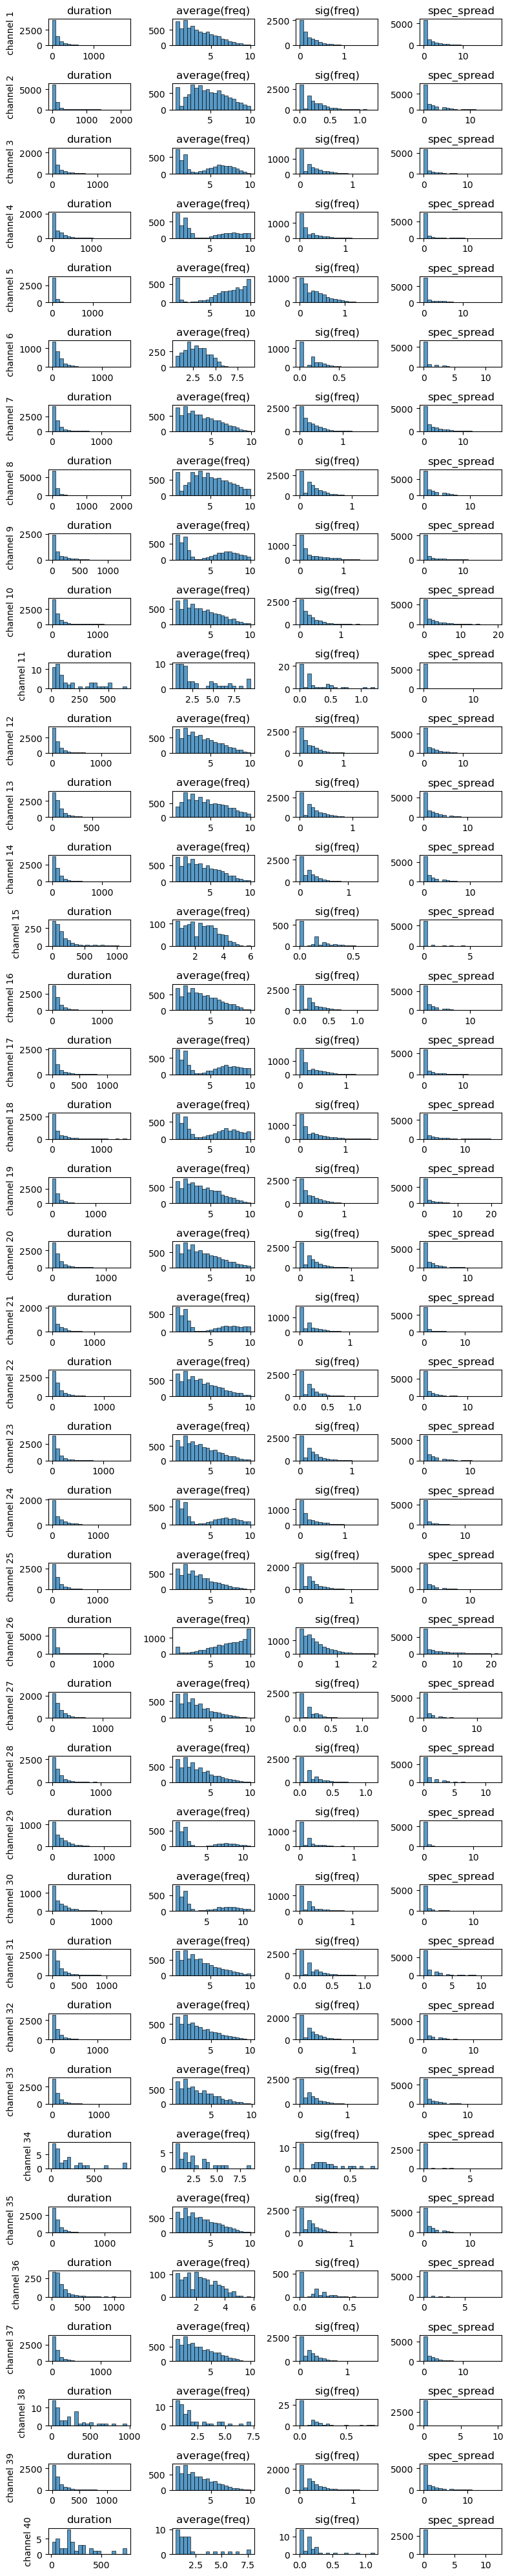

In [22]:
plt.figure(figsize=(8, 40))
pos = 1
for c in range(len(features_slow)):
    for i in [2, 4, 5, 6]:
        data = features_slow[c][i]
        if data.ndim == 3:
            data = np.diff(data.reshape(-1, 2), axis=1)
        data = data.flatten()
        data = data[~np.isnan(data)]
        plt.subplot(40, 4, pos)
        sns.histplot(data=data, bins=20)
        plt.title(features_names[i])
        if i == 2:
            plt.ylabel(f"channel {c + 1}")
        else:
            plt.ylabel(f"")
        pos = pos + 1
plt.tight_layout()

plt.savefig(os.path.join(impath, f"features_slow_{condition}.png"))

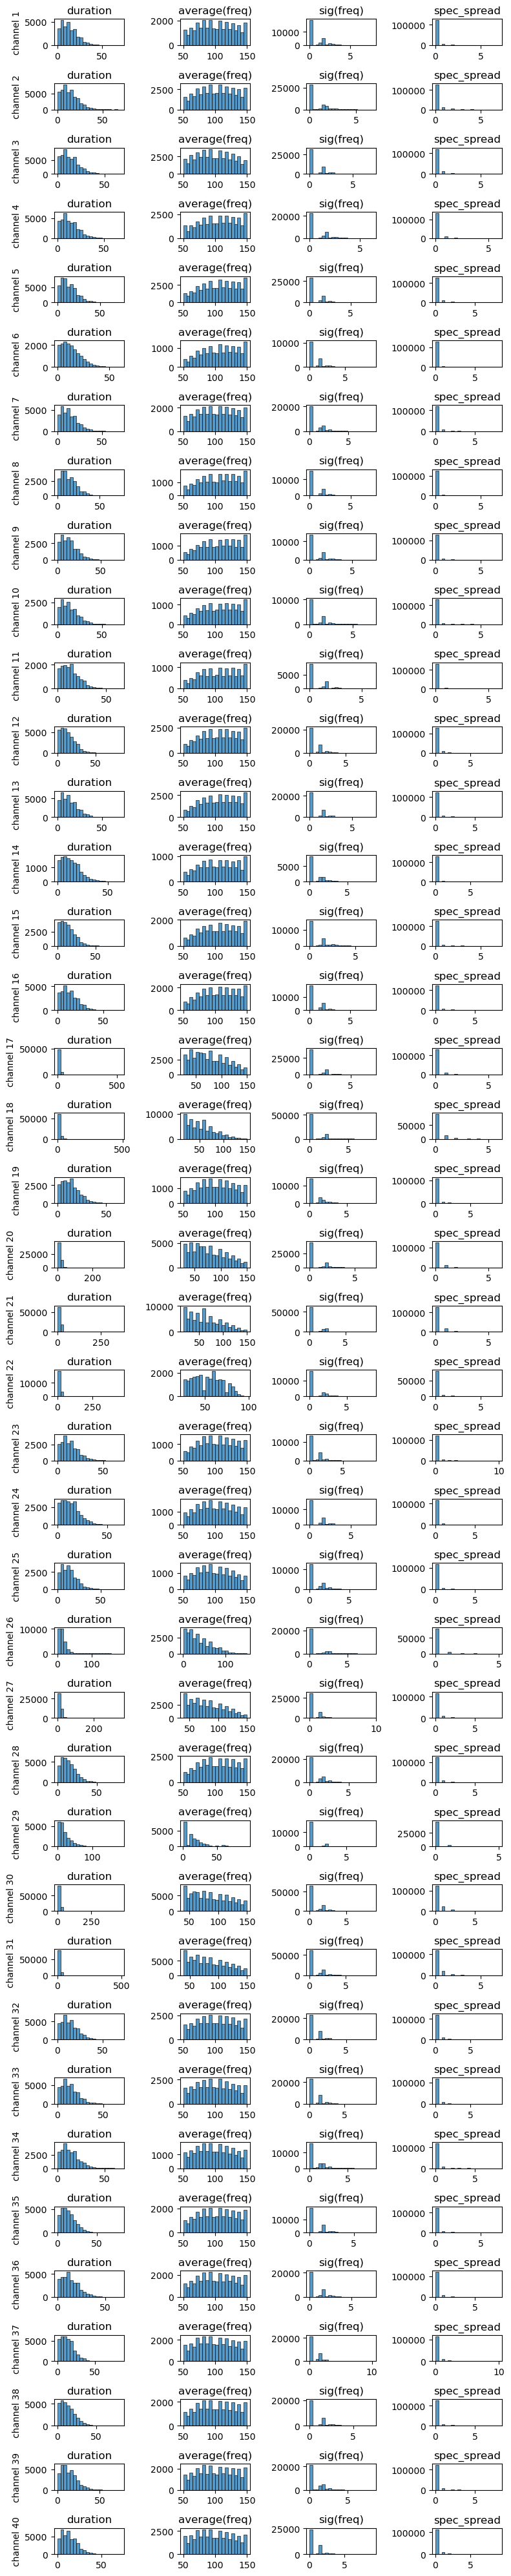

In [23]:
plt.figure(figsize=(8, 40))
pos = 1
for c in range(len(temp)):
    for i in [2, 4, 5, 6]:
        data = temp[c][i]
        if data.ndim == 3:
            data = np.diff(data.reshape(-1, 2), axis=1)
        data = data.flatten()
        data = data[~np.isnan(data)]
        plt.subplot(40, 4, pos)
        sns.histplot(data=data, bins=20)
        plt.title(features_names[i])
        if i == 2:
            plt.ylabel(f"channel {c + 1}")
        else:
            plt.ylabel(f"")
        pos = pos + 1
plt.tight_layout()
plt.savefig(os.path.join(impath, f"features_fast_{condition}.png"))

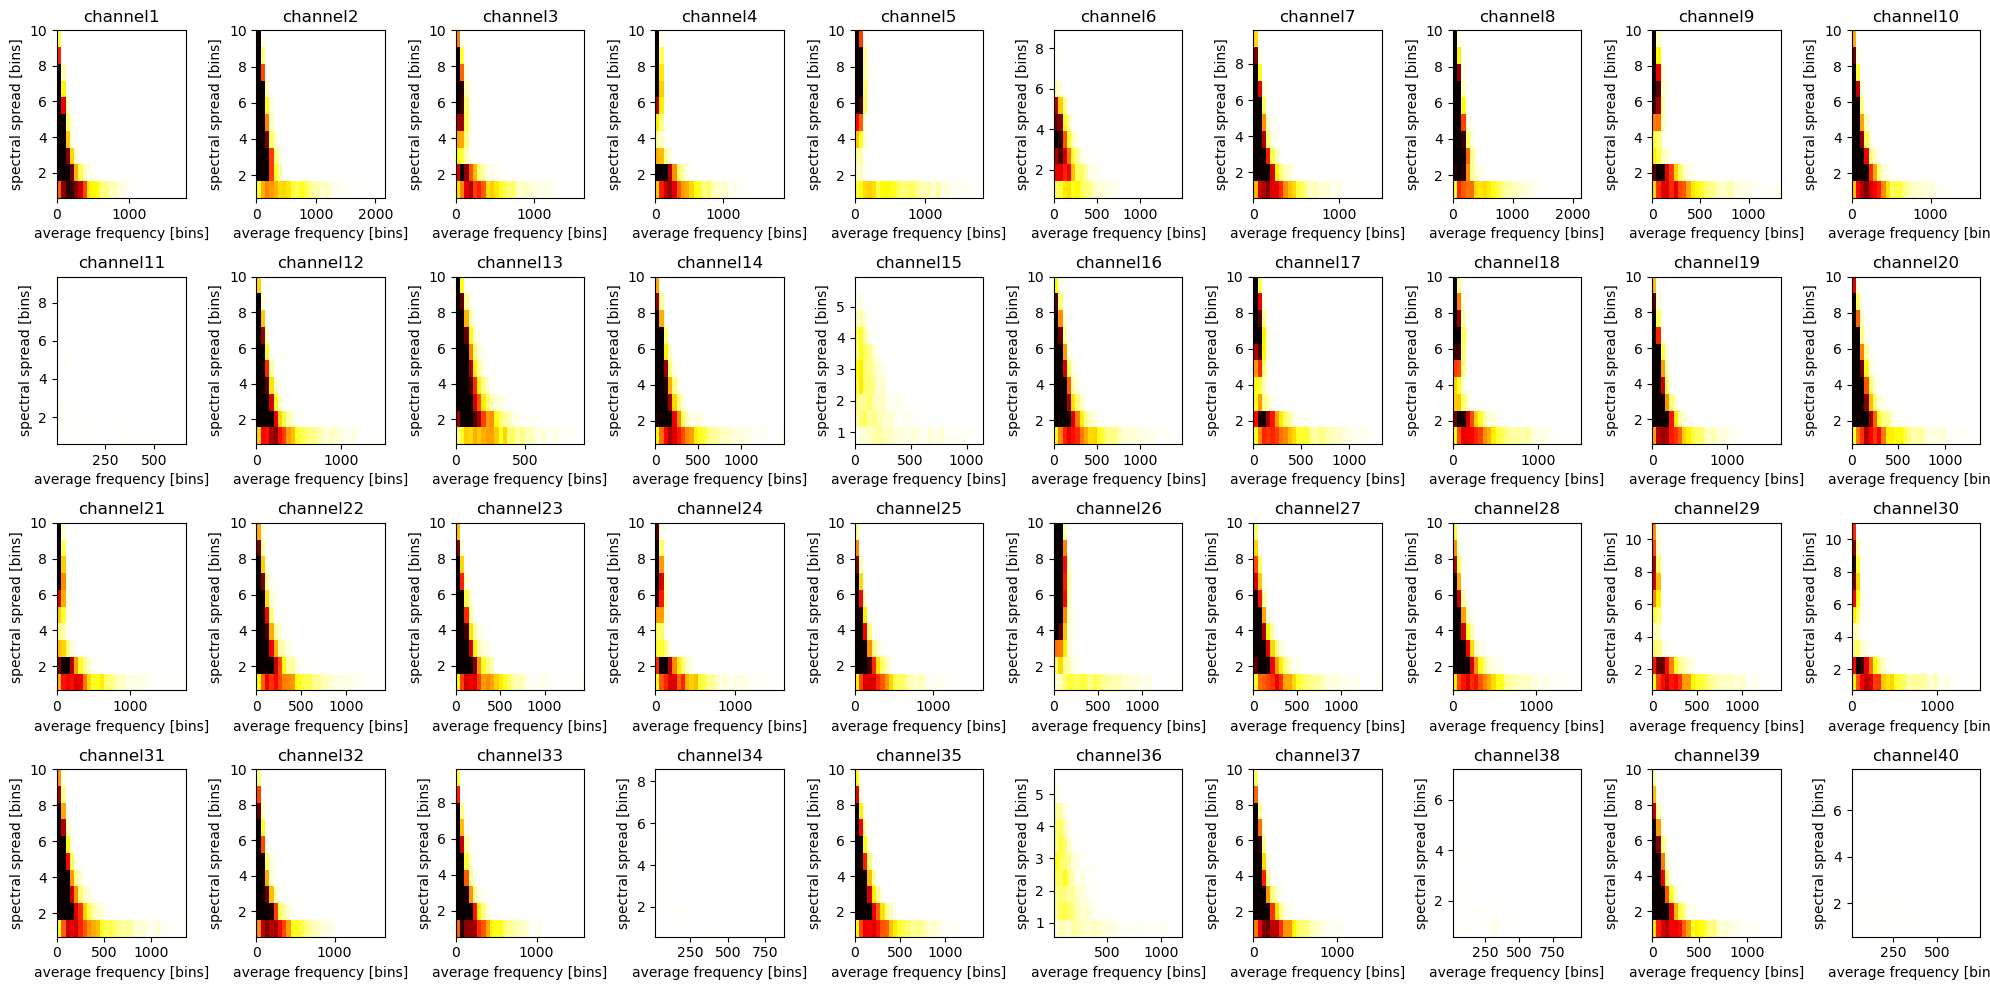

In [24]:
plt.figure(figsize=(20, 10))
for c in range(40):
    plt.subplot(4, 10, c + 1)
    x = features_slow[c][2].flatten()
    y = features_slow[c][4].flatten()
    idx = ~np.logical_or(np.isnan(x), np.isnan(y))
    plt.hist2d(
        x[idx],
        y[idx],
        bins=(30, 10),
        cmap="hot_r",
        vmax=200,
    )
    plt.title(channels[c])
    plt.ylabel("spectral spread [bins]")
    plt.xlabel("average frequency [bins]")
plt.tight_layout()

plt.savefig(os.path.join(impath, f"duration_frequency_dist_slow_{condition}.png"))

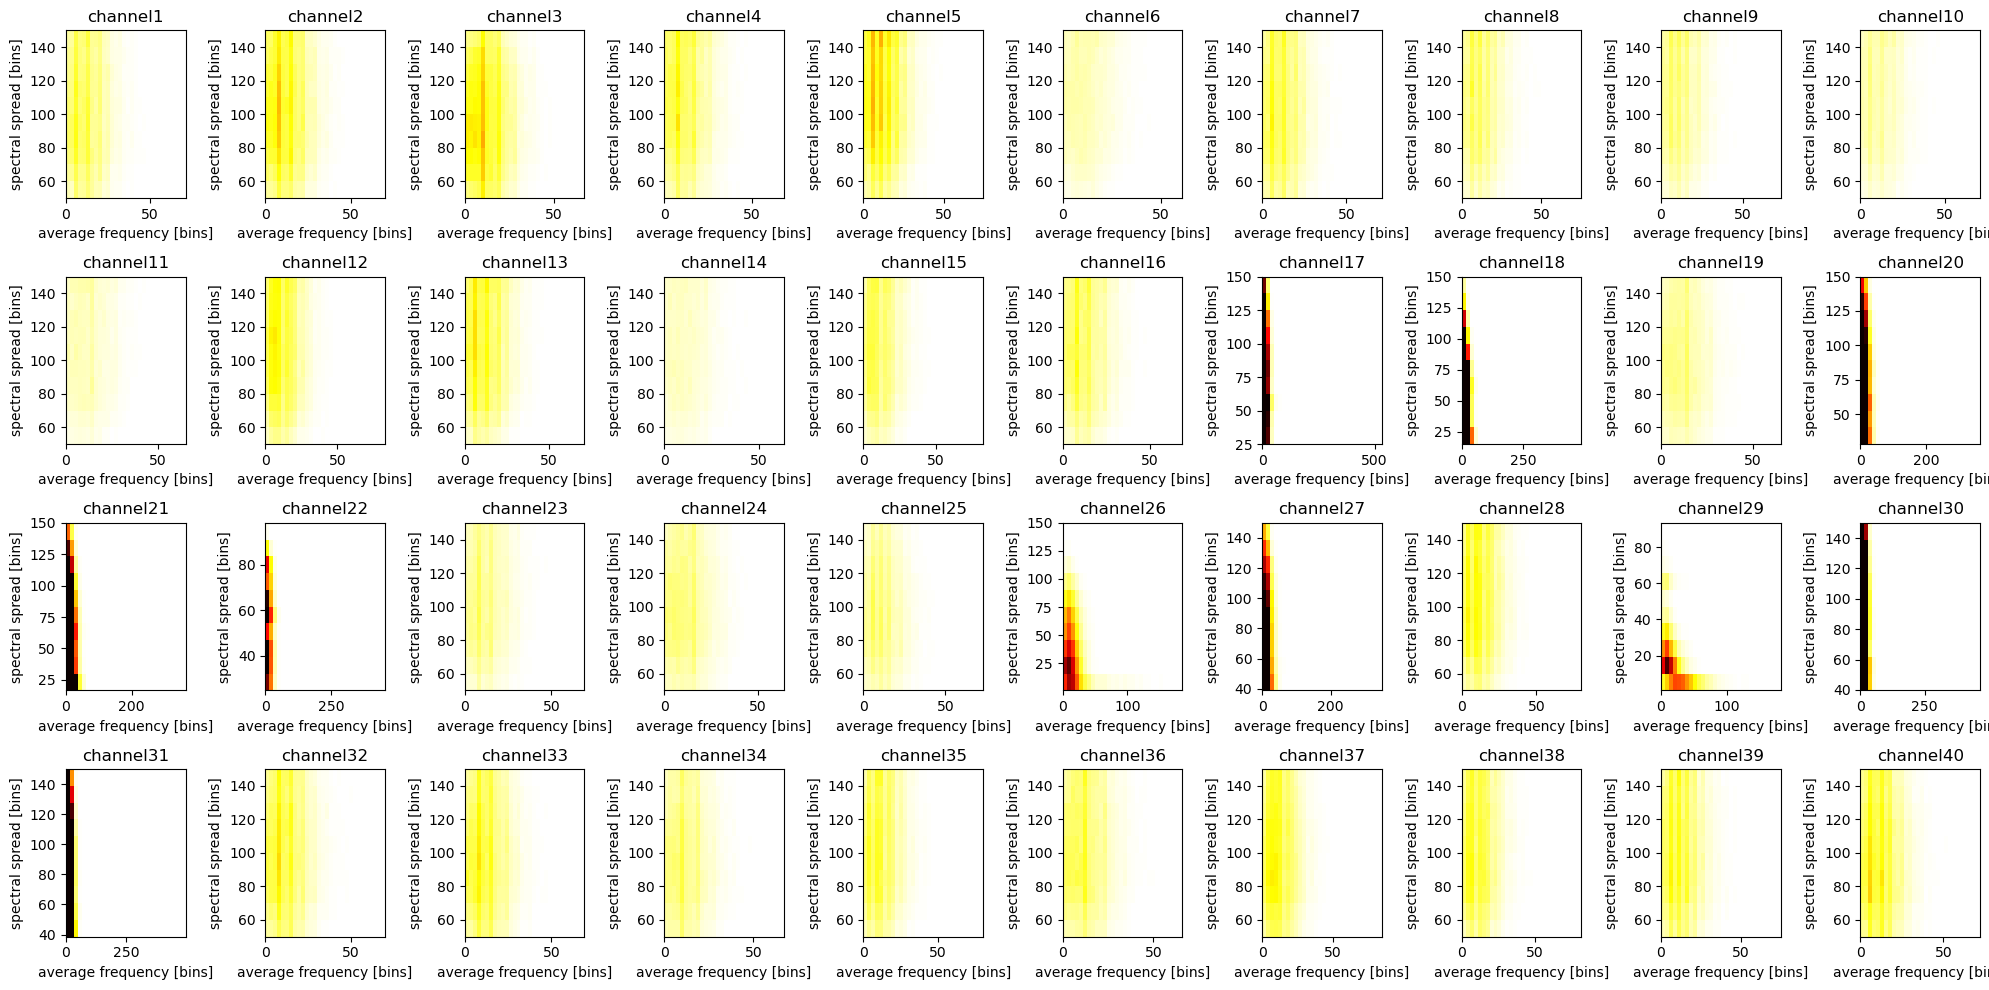

In [25]:
plt.figure(figsize=(20, 10))
for c in range(40):
    plt.subplot(4, 10, c + 1)
    x = temp[c][2].flatten()
    y = temp[c][4].flatten()
    idx = ~np.logical_or(np.isnan(x), np.isnan(y))
    plt.hist2d(
        x[idx],
        y[idx],
        bins=(30, 10),
        cmap="hot_r",
        vmax=2000,
    )
    plt.title(channels[c])
    plt.ylabel("spectral spread [bins]")
    plt.xlabel("average frequency [bins]")
plt.tight_layout()

plt.savefig(os.path.join(impath, f"duration_frequency_dist_fast_{condition}.png"))

In [26]:
def _for_channel(channel):

    slow_timings = features_slow[channel][3]
    fast_timings = temp[channel][3]

    noverlaps = []

    for i in range(200):
        _slow_timings = np.diff(slow_timings[i], axis=1).squeeze()
        _slow_timings = slow_timings[i][_slow_timings > 0, :]

        _fast_timings = np.diff(fast_timings[i], axis=1).squeeze()
        _fast_timings = fast_timings[i][_fast_timings > 0, :]

        noverlaps += [overlaps(_slow_timings, _fast_timings)]

    return np.hstack(noverlaps)

In [27]:
n_overlaps = [_for_channel(channel) for channel in tqdm(range(nchannels))]

100%|█████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.13it/s]


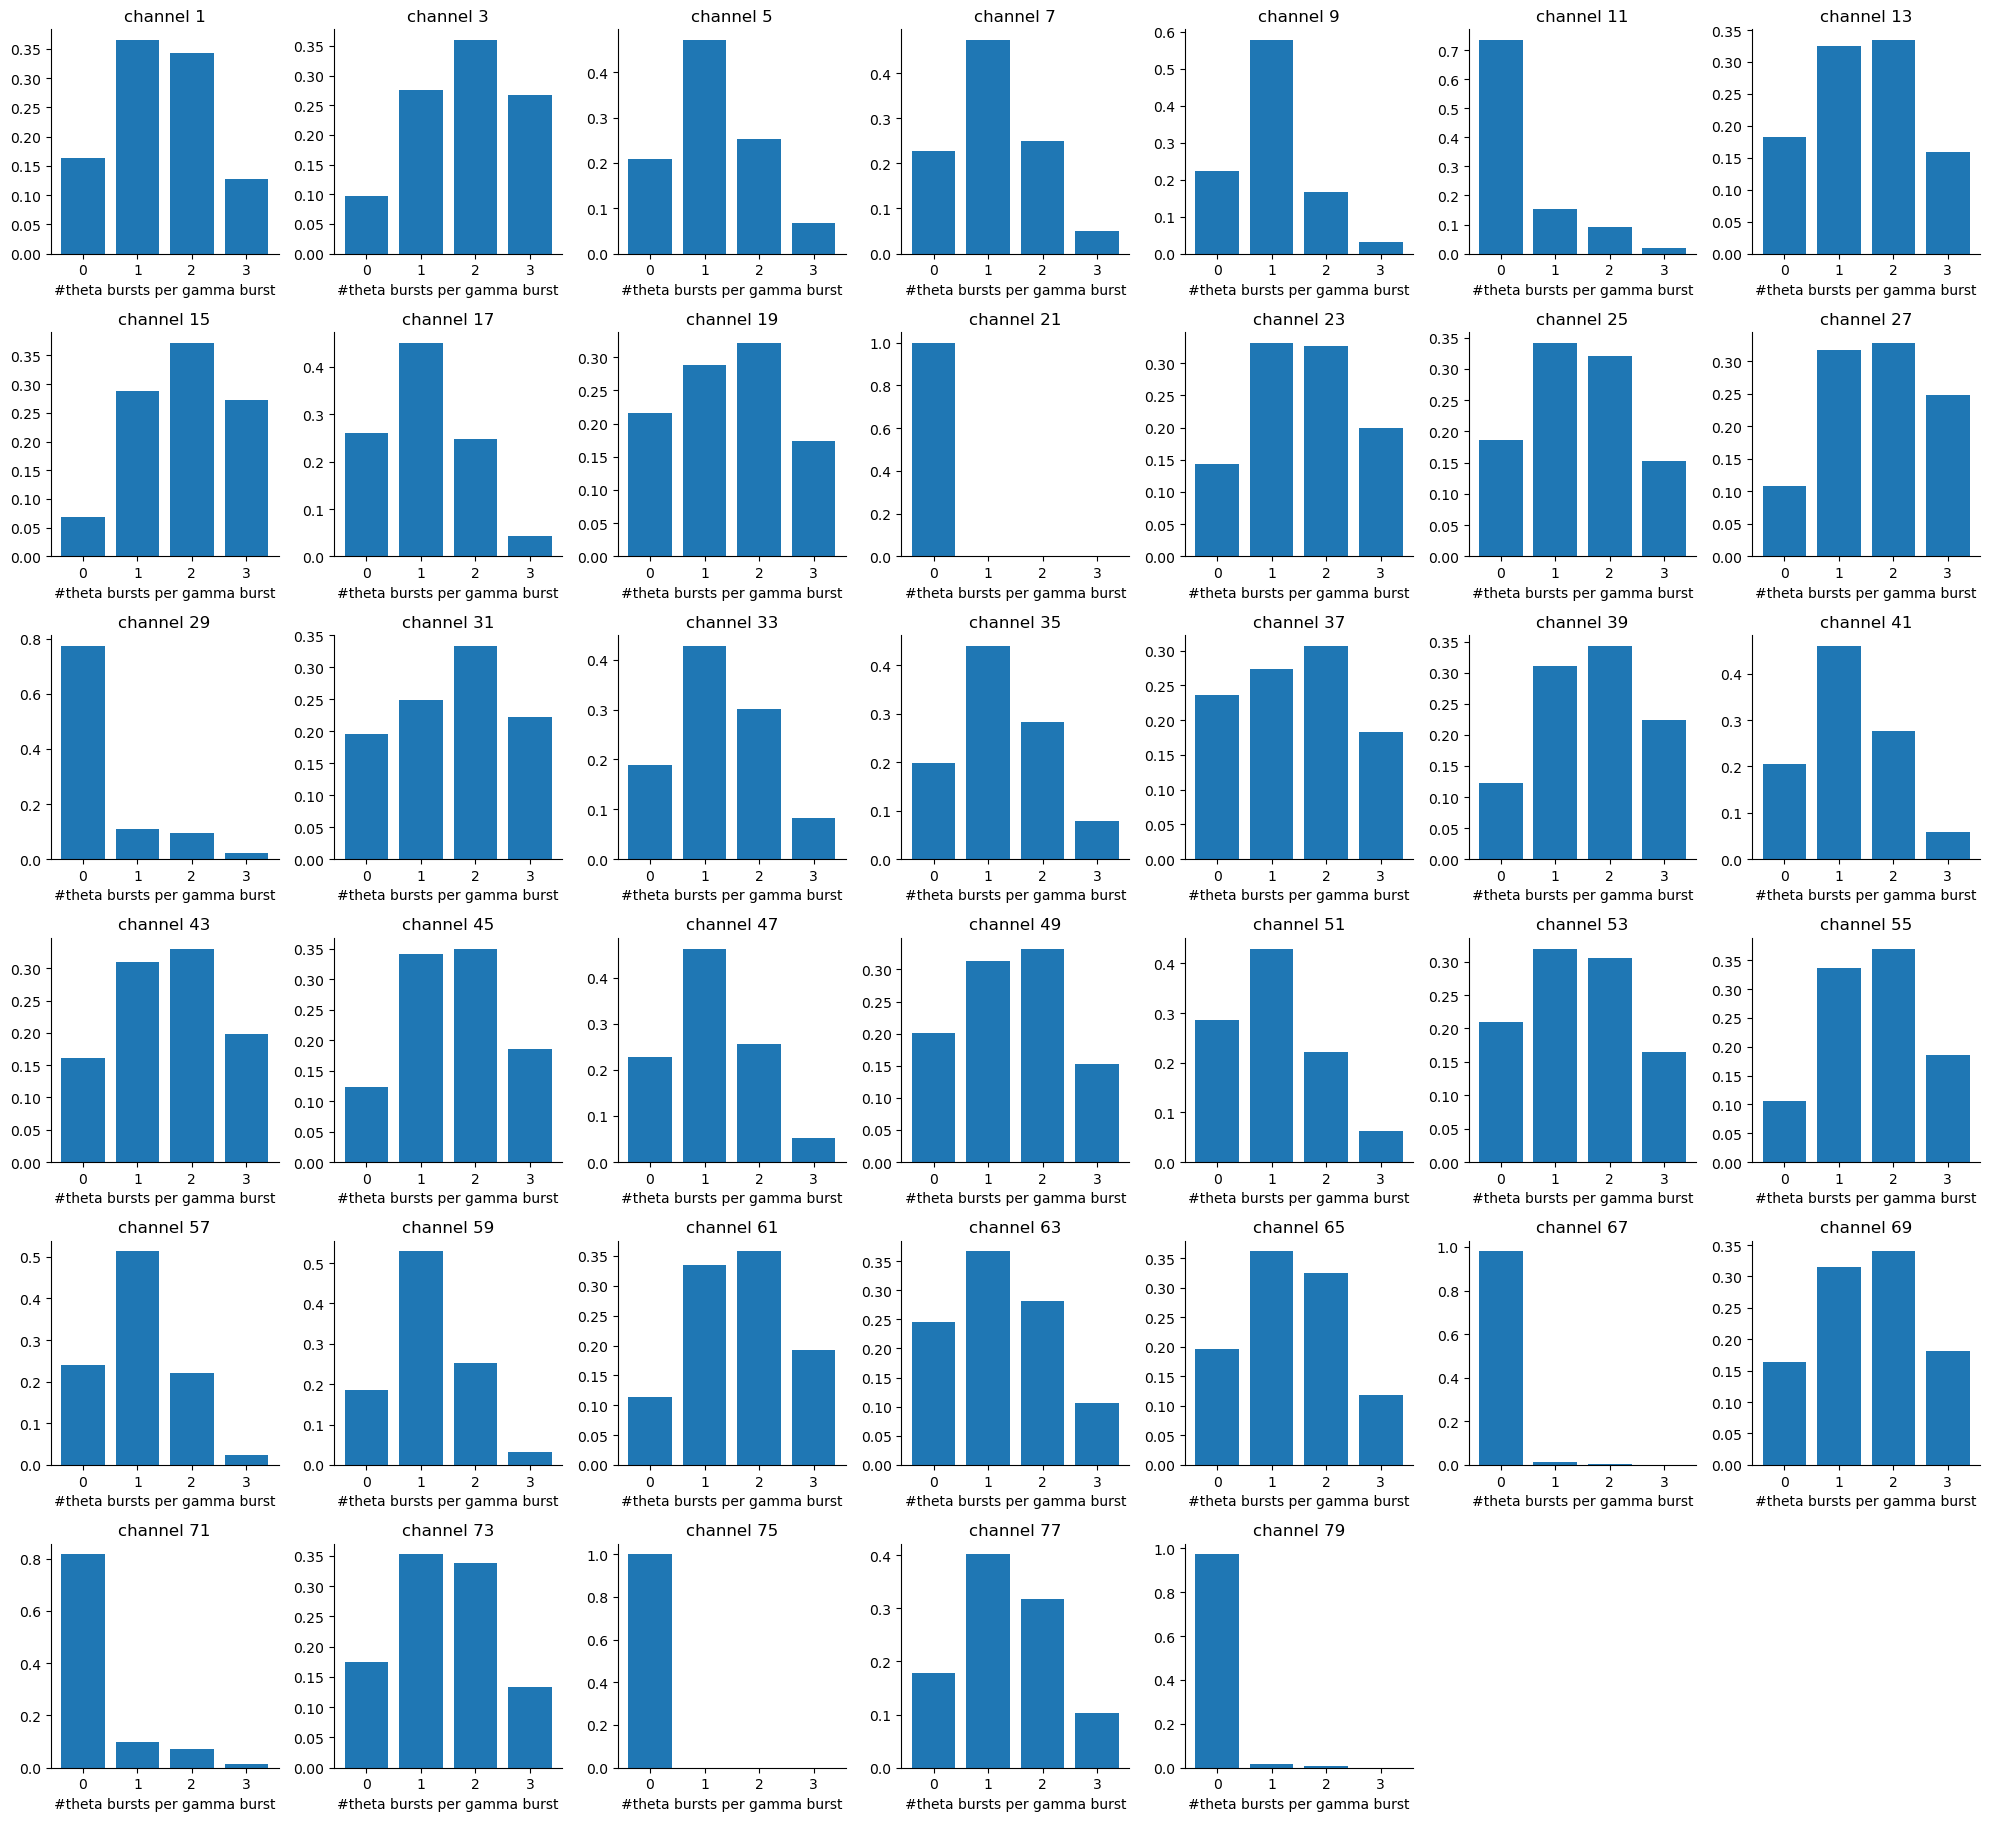

In [29]:
plt.figure(figsize=(20, 30))
pos = 1
for i in range(nchannels):
    ax = plt.subplot(10, 7, i + 1)
    n, x = np.histogram(n_overlaps[i], bins=[0, 1, 2, 3, 4])
    plt.bar(x[:-1], n / n.sum())
    plt.xlabel("#theta bursts per gamma burst")
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"channel {pos}")
    pos = pos + 2
plt.tight_layout()
plt.savefig(os.path.join(impath, f"theta_per_gamma_{condition}.png"))